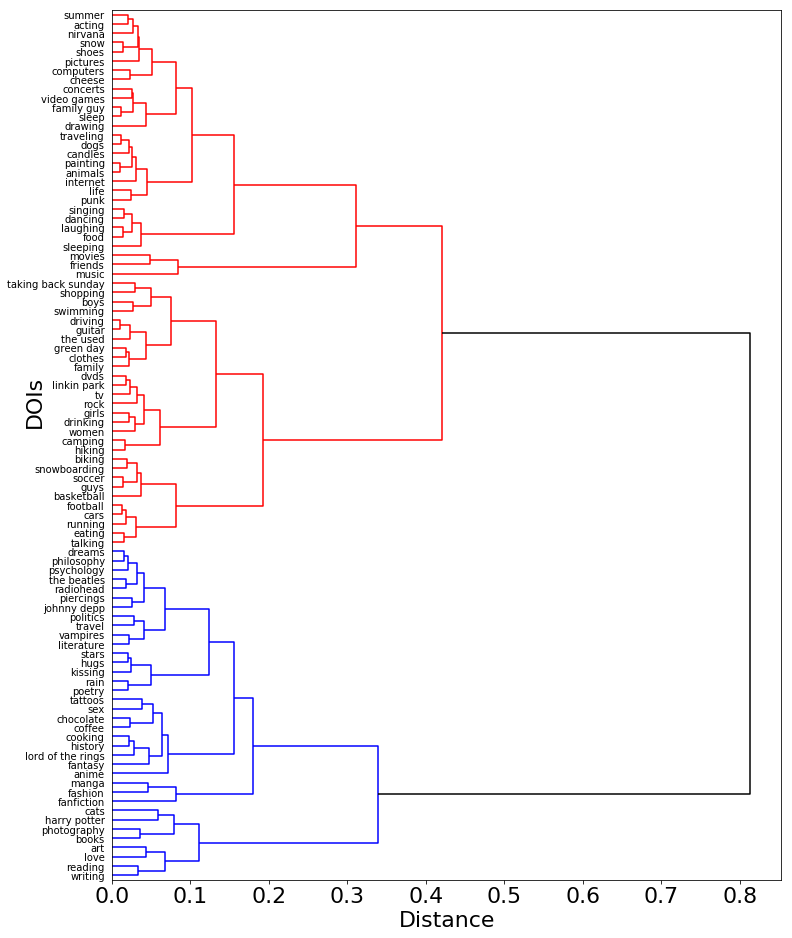

In [23]:
# -*- coding: utf-8 -*-
# unsupervised cluster analysis of correlation of Free Text with Network Topology 
"""
algorithms we used:
*Hierarchical
*Kmeans
*DBSCAN
@author: Yuval Samoilov-Katz
"""

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
plt.rcParams.update({'font.size': 22})

# Hierarchical Agglomerative Clustering
snaps = [19]
for snap in snaps:
    dataset = pd.read_csv('Data/snap_{}_dois_100.csv'.format(snap))
    X = dataset.iloc[:, 1:20].values
    DOIs = dataset['DOIs'].values
    base = np.arange(0,len(DOIs),1)
    
    ## Hierarchical analysis to explore main clusters
    fig, ax = plt.subplots(figsize=(12,16), nrows=1, ncols=1)

    #fig, axes = plt.subplots(figsize=(16,12), nrows=1, ncols=3)
    methods = ['ward']
    exp = ['Minimium Variance']
    '''
    #methods = ['average','complete','ward']
    #exp = ['Average Distances','Maximum Distances','Minimium Variance']
    for i,m in enumerate(methods):
        ### visualize dendogram
        dend1 = shc.dendrogram(shc.linkage(X, method=m),labels=DOIs , orientation='right',ax=axes[i])
        axes[i].title.set_text(f'{exp[i]} Hierarchy')
        if i ==2:
            axes[i].axvline(x=0.55, color='black',label='2 main\nclusters') 
        elif i==1:
            axes[i].axvline(x=0.28, color='black',label='2 main\nclusters') 
            axes[i].axvline(x=0.22, linestyle='--',label='3') 
        else:
            axes[i].axvline(x=0.155, color='black',label='2 main\nclusters') 
            axes[i].axvline(x=0.11, linestyle='--',label='4') 
    '''      
    hierarchy.set_link_color_palette(['b', 'r','k'])
    dend1 = hierarchy.dendrogram(hierarchy.linkage(X, method=methods[0]),labels=DOIs ,above_threshold_color='k', orientation='right',ax=ax)
    ax.set_xlabel('Distance')
    ax.set_ylabel('DOIs')
    ax.yaxis.set_label_coords(-0.1,0.55)
    ax.tick_params(axis='y', labelsize=10)
    plt.savefig(f'Results/Hierarchical_{snap}.tiff',dpi=150)
    


In [ ]:
'''
#KMeans Clustering
clusters = [2,3,5]
for snap in snaps:
    dataset = pd.read_csv('Data/snap_{}_dois_100.csv'.format(snap))
    X = dataset.iloc[:, 1:20].values
    DOIs = dataset['DOIs'].values
    base = np.arange(0,len(DOIs),1)
    ## Kmeans analysis
    fig, ax = plt.subplots(figsize=(14,10), nrows=5, ncols=1)    
    for j, cluster in enumerate(clusters):
        kmeans = KMeans(n_clusters=cluster)
        kmeans.fit(X)
    
        for i,feature in enumerate(dataset.columns[:-1]):
            ax[0].scatter(base, X[:,i], label=f'{feature}')
            ax[j+1].scatter(base, X[:,i], c=kmeans.labels_, cmap='rainbow')

    
        ax[0].title.set_text(f'Snap:{snap}\nCorrelation of Free Text with Network Topology')
        ax[0].set_ylabel('Corr')
        ax[j+1].title.set_text(f'KMeans with {cluster} Clusters')
        ax[j+1].set_ylabel('Corr')
    ax[3].set_xlabel('DOI"s Number')

    ### Elbow method to determine the number of clusters
    distortions = []
    K = range(1,20)
    for k in K:
        kmeanModel = KMeans(n_clusters=k).fit(X)
        kmeanModel.fit(X)
        distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])                   
    
    ax[4].plot(K, distortions, 'bx-')
    ax[4].set_xlabel('k')
    ax[4].set_ylabel('Distortion')
    ax[4].title.set_text('The Elbow Method - optimal k')

    plt.tight_layout()
    plt.savefig(f'Results/Kmeans_{snap}')
    
'''

In [ ]:
'''
# DBSCAN
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

snaps = [1,2,10,19]

min_samples = range(2,6) # smallest number of DOIs to cluster together
epes = range(1,40) # integers to iterate over represents radios of neighbors to cluster together

## preprocessing - exploring number of min_sample and epsilons for DBSCAN
for s in min_samples:
    fig, ax = plt.subplots(figsize=(14,10), nrows=4, ncols=1)    
    for i,snap in enumerate(snaps):
        #preprocess data
        dataset = pd.read_csv('Data/snap_{}_dois_100.csv'.format(snap))
        labels_true = dataset.iloc[:,0]
        x = StandardScaler().fit_transform(dataset.iloc[:,1:])  
        
        #test different variations
        clusters = []
        noises = []
        epsilons = []
        for e in epes:
            db = DBSCAN(eps=(e/10),min_samples=s).fit(x)
            core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
            core_samples_mask[db.core_sample_indices_] = True
            labels = db.labels_
            n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
            
            #only optional clusters
            if n_clusters_>1:
                epsilons.append(e/10)
                clusters.append(n_clusters_)
                n_noise_ = list(labels).count(-1)
                noises.append(n_noise_)

        #label the data points
        for j,_ in enumerate(clusters):
           ax[i].annotate(f'{clusters[j],noises[j]}',(epsilons[j], clusters[j]))
        
        #draw the data
        ax[i].scatter(epsilons, clusters)
        ax[i].set_title(f'snap:{snap}\nDBSCAN analysis with min_sample:{s} (clusters,noise)')
        ax[i].set_ylabel('N clusters')
        ax[i].set_xlabel('epsilon')

    plt.tight_layout()
    plt.savefig(f'Results/DBSCAN_exploring_clusters_min{s}')
    

#test spesific combination of e and min_sample for DBSCAN clustering
plt.clf()
min_sample = 5
e = 1.0

## using optimal epsilons for DBSCAN

fig, ax = plt.subplots(figsize=(14,10), nrows=4, ncols=1)    
for i,snap in enumerate(snaps):
    dataset = pd.read_csv('Data/snap_{}_dois_100.csv'.format(snap))
    labels_true = dataset.iloc[:,0]
    x = StandardScaler().fit_transform(dataset.iloc[:,1:])

    db = DBSCAN(eps=e,min_samples=min_sample).fit(x)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    #some statistics
    #print('Estimated number of clusters: %d' % n_clusters_)
    #print('Estimated number of noise points: %d' % n_noise_)
    #print("Homogeneity: %0.3f\n1 is aperfect homogeneity" % metrics.homogeneity_score(labels_true, labels))
    #print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
    #print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
    #print("Adjusted Rand Index: %0.3f"% metrics.adjusted_rand_score(labels_true, labels))
    #print("Adjusted Mutual Information: %0.3f"% metrics.adjusted_mutual_info_score(labels_true, labels))
    #print("Silhouette Coefficient: %0.3f"% metrics.silhouette_score(X, labels))

    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)
        xy = X[class_member_mask & core_samples_mask]
        ax[i].plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)

        xy = X[class_member_mask & ~core_samples_mask]
        ax[i].plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)
    hmg = metrics.homogeneity_score(labels_true, labels)
    ax[i].set_title(f'Estimated number of clusters: {n_clusters_}\nHomogenety score:{hmg:.3f}')
    
plt.tight_layout()
plt.savefig('Results/DBSCAN_e{0}_s{1}.jpeg'.format(e,min_sample))
'''


### 